# Prognoza sprzedaży

Zastosowany zostanie model SARIMAX.
Więcej informacji: https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

## 1. Import bibliotek

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta, datetime, timezone
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
import joblib
import warnings

## 2. Import danych

In [89]:
sale_total = pd.read_excel("sprzedaz_total.xlsx", sheet_name=0)
sale_total.head()

,data,Między wielkością a zanikiem,Mała degeneracja,Od foliowych czapeczek...,Koniec końca historii,Iluzja wolnej Białorusi,Polska za linią Curzona,Wdowa smoleńska,Rzeczpospolita trzecia i pół,Świat narodów zagubionych,Upadła praworządność,Polska w nowym świecie,Pisma geopolityczne,"Propaganda, która zabija",Wielkie złudzenie
0,2020-10-21,15,9,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-10-22,25,11,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-10-23,23,6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-10-24,21,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-10-25,16,7,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Czyszczenie danych

### 3.1. Przygotowanie zbioru danych do prognoz

In [90]:
# Make the date column a datetime object
pd.to_datetime(sale_total["data"], format="%d-%m-%y")

# Set date to index (it should be done so!)
sale_total = sale_total.set_index("data")


## 4. Eksploracja całego zbioru

### 4.1. Sprawdzenie wzorców, jakie powtarzają się w szeregach czasowych
-<b>Poziom</b> - średnia wartość w szeregu<br>
-<b>Trend</b> - wznoszący, opadający czy stały?<br>
-<b>Sezonowość</b><br>
-<b>Cykliczność</b><br>
-<b>Losowe lub nieregularne zróżnicowanie</b>

#### 4.2.1. Wykres sprzedaży

Spróbujmy zrobić wykres sprzedaży wszystkich książek dzień po dniu.

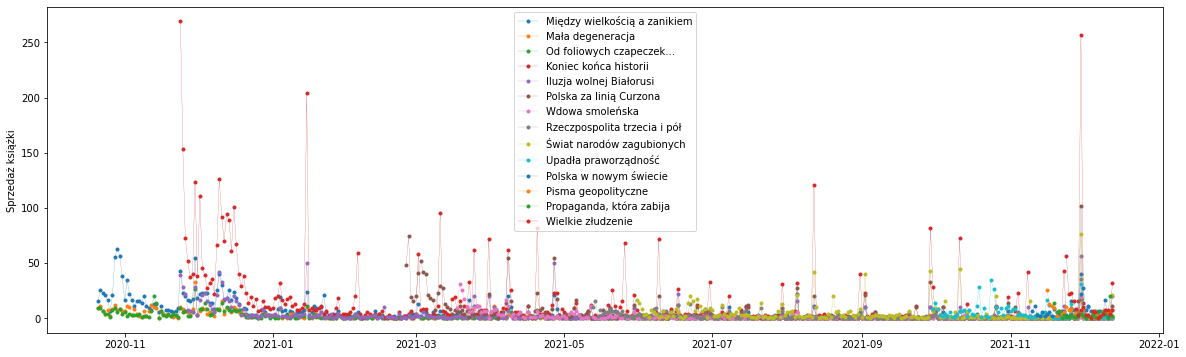

In [91]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(20,6))

# Loop over all books and plot
for book in sale_total:
    y = sale_total[book]
    ax.plot(y, marker=".", linestyle="-", linewidth=0.2, label=book)

ax.set_ylabel("Sprzedaż książki")
ax.legend();
    

Nic nie widać na tym wykresie. A może zmienić okres badany na miesiąc i zmienić wielkość wykresu?

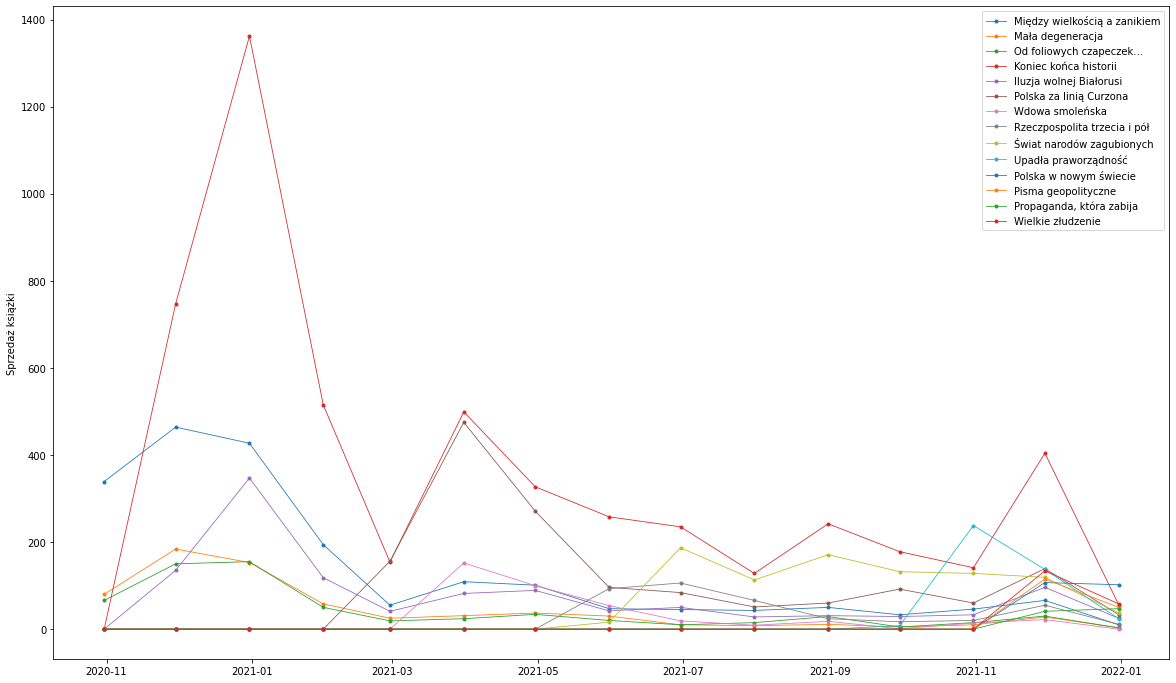

In [92]:
# Resample the dataframe to monthly periods
sale_monthly = sale_total.resample("M").sum()

# Create figure and axes
fig, ax = plt.subplots(figsize=(20,12))

# Loop over all books and plot
for book in sale_monthly:
    y = sale_monthly[book]
    ax.plot(y, marker=".", linestyle="-", linewidth=0.8, label=book)

ax.set_ylabel("Sprzedaż książki")
ax.legend();
    

Nadal niewiele widać. Trzeba podzielić zbiór danych na mniejsze kawałki - słowem prognozować dla każdej książki z osobna. Zacznijmy od "Między wielkością a zanikiem".

## 5. "Między wielkością a zanikiem" - prognozy

### 5.1. Eksploracyjna analiza danych

#### 5.1.1. Stworzenie serii czasowej dot. książki


In [93]:
df = sale_total["Między wielkością a zanikiem"]

#### 5.1.2. Wykres liniowy sprzedaży książki

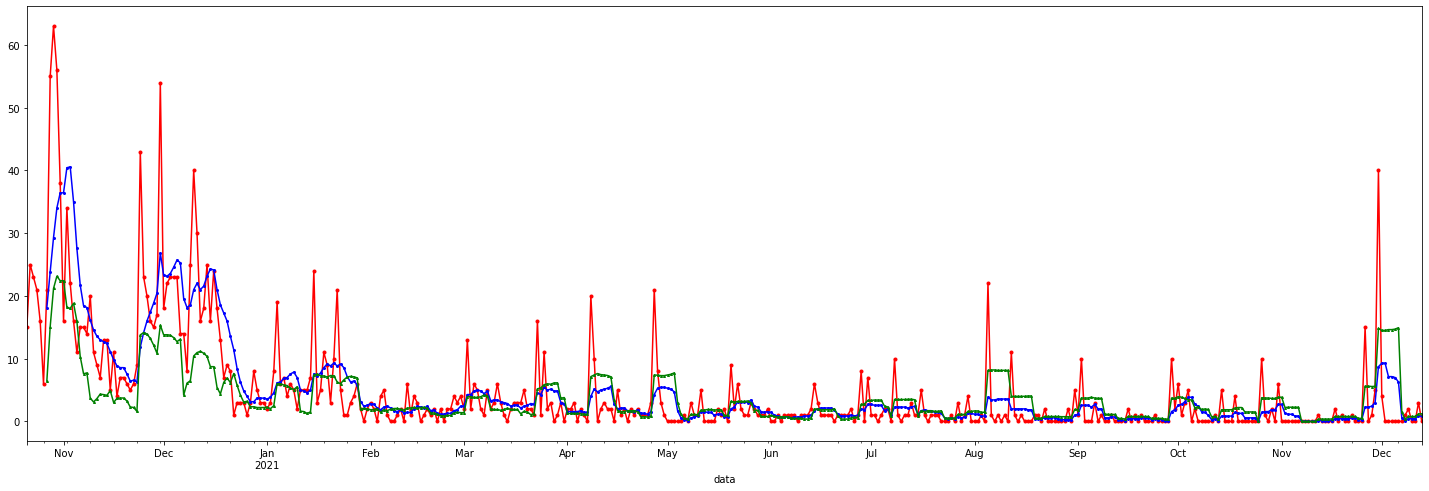

In [94]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(25,8))

# Plot the daily sales
_ = df.plot(ax=ax, marker=".", linestyle="-", color="red", label = "Daily")

# Plot the rolling mean and standard deviation
df_rolling_mean = pd.Series(df).rolling(window=7).mean()
df_rolling_std = pd.Series(df).rolling(window=7).std()

# Plot the rolling mean and standard deviation
_ =  ax.plot(df_rolling_mean, marker="o", markersize=2, linestyle="-", color="blue", label = "Rolling Mean")
_ =  ax.plot(df_rolling_std, marker="^", markersize=2, linestyle="-", color="green", label = "Rolling StDev")
plt.show()

Wykres wskazuje na znaczącą różnicę między danymi do ok. połowy stycznia 2021 i później. <br>
Zmienia się średnia i odchylenie standardowe.<br>
Czy jest sezonowy i stacjonarny? Trudno powiedzieć na podstawie samego wykresu. Zróbmy testy.

##### 5.1.3. Test stacjonarności - <i>augmented Dickey-Fuller</i>

In [95]:
# Import test
from statsmodels.tsa.stattools import adfuller

# Get results
adf_results = adfuller(df)

# Print values
print("WYNIKI WZMOCNIONEGO TESTU DICKEYA-FULLERA\n")
print(f"Wartość testu Dickeya-Fullera: {adf_results[0]}.\nIm bardziej ujemna wartość - tym większe prawdopodobieństwo, że szereg czasowy jest stacjonarny.")
print(f"Wartość p: {round(adf_results[1],2)}.")
# Round the critical values
rounded_criticals = {key: round(value, 2) for key, value in adf_results[4].items()} 
print(f"Wartości krytyczne p: {rounded_criticals}.\n")



WYNIKI WZMOCNIONEGO TESTU DICKEYA-FULLERA

Wartość testu Dickeya-Fullera: -3.4104205825150564.
Im bardziej ujemna wartość - tym większe prawdopodobieństwo, że szereg czasowy jest stacjonarny.
Wartość p: 0.01.
Wartości krytyczne p: {'1%': -3.45, '5%': -2.87, '10%': -2.57}.



Wygląda na to, że nasz szereg czasowy jest stacjonarny. Nie chce się w to za bardzo wierzyć :)<br>
Sprawdźmy wszystkie wyniki testu ADF.

In [96]:
adf_results

(-3.4104205825150564,
 0.010608722802444404,
 5,
 413,
 {'1%': -3.4462831955497135,
  '5%': -2.8685636962704395,
  '10%': -2.5705114078759914},
 2444.1422701738015)

OK. Jest stacjonarny. Mniej roboty dla mnie.

#### 5.1.4. Sprawdzenie sezonowości

<b>Dekompozycja sezonowa</b>

1) Identyfikacja okresu sezonowego

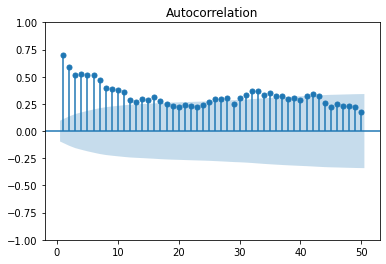

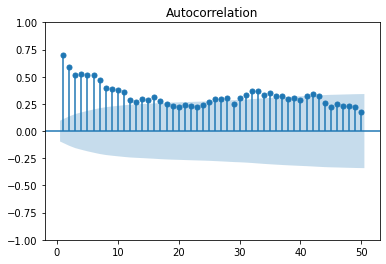

In [97]:
fig, ax = plt.subplots()
plot_acf(df, lags=50, zero=False, ax=ax)

OK, wygląda na to, że nie jest to sezonowy szereg czasowy.

### 5.2. Tworzenie modelu

#### 5.2.1. Znajdowanie odpowiedniego rzędu dla modelu

In [98]:
# Ignore warnings
warnings.filterwarnings("ignore")
# Create an empty list
order_aic_bic = []
# Loop over AR and MA order
for p in range(3):
    for q in range(3):
        # Make model and fit it, and append order and scores to the list
        try:
            model = SARIMAX(df, order=(p,0,q))
            results = model.fit()
        except ValueError:
            print(p, q, None, None)
        order_aic_bic.append((p, q, results.aic, results.bic))
# Convert the list to a DF
order_df = pd.DataFrame(order_aic_bic, columns = ["p", "q", "aic", "bic"])
# Step 5. Sort by AIC and print
print(order_df.sort_values("aic"))



   p  q          aic          bic
7  2  1  2681.336713  2697.488196
8  2  2  2682.604877  2702.794232
5  1  2  2686.393526  2702.545010
4  1  1  2699.606352  2711.719964
6  2  0  2719.254551  2731.368164
3  1  0  2739.102958  2747.178699
2  0  2  2827.473479  2839.587092
1  0  1  2918.260535  2926.336277
0  0  0  3117.897866  3121.935737


#### 5.2.2. Tworzenie i dopasowanie modelu

In [99]:
# Instantiate a model
model = SARIMAX(df, order=(2,0,1))

# Fit the model
results=model.fit()

# Forecast for the next 365 days
forecast = results.get_forecast(steps=383).predicted_mean

confidence = results.get_forecast(steps=383).conf_int()
confidence.columns = ["lower", "upper"]
for i in range(len(confidence)):
    if confidence["lower"][i] < 0:
        confidence["lower"] = 0

forecast

2021-12-14    1.137917
2021-12-15    1.599691
2021-12-16    1.785627
2021-12-17    1.859035
2021-12-18    1.886540
                ...   
2022-12-27    0.849971
2022-12-28    0.848135
2022-12-29    0.846303
2022-12-30    0.844475
2022-12-31    0.842650
Freq: D, Name: predicted_mean, Length: 383, dtype: float64

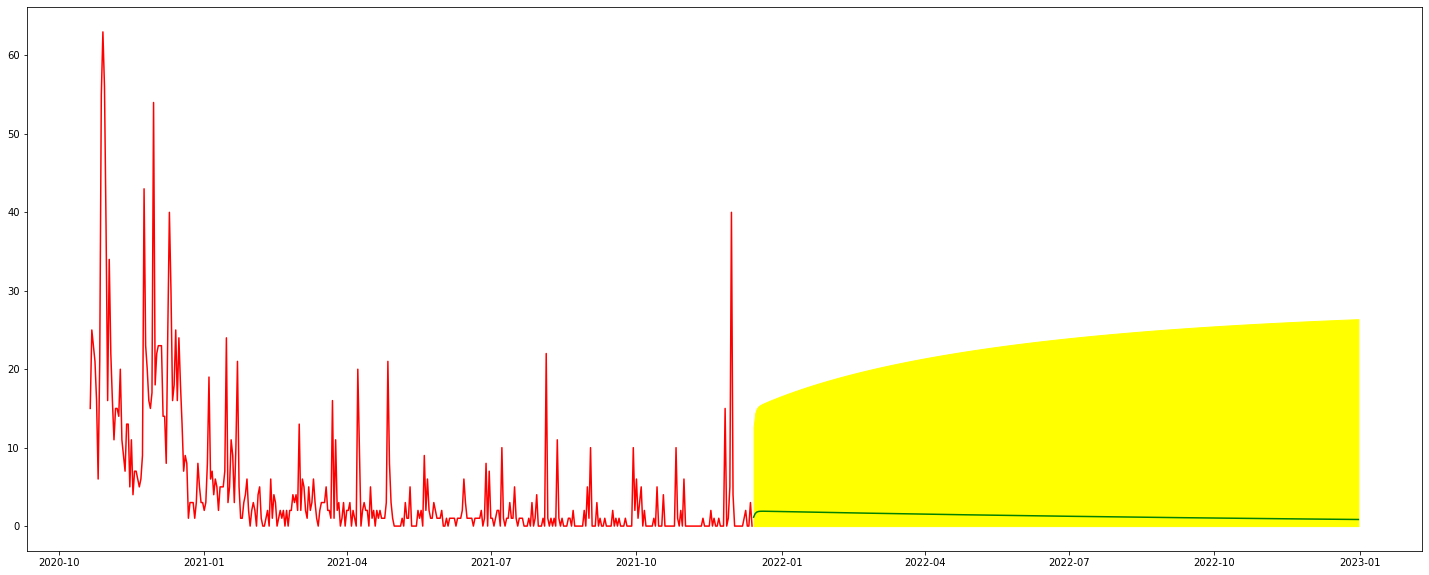

In [100]:
plt.figure(figsize=(25,10))
_ = plt.plot(df, color="red", label="up-to-now")
_ = plt.plot(forecast, color="green", label="prediction")
_ = plt.fill_between(forecast.index, confidence["lower"], confidence["upper"], color="yellow")

### 5.3. Diagnostyka

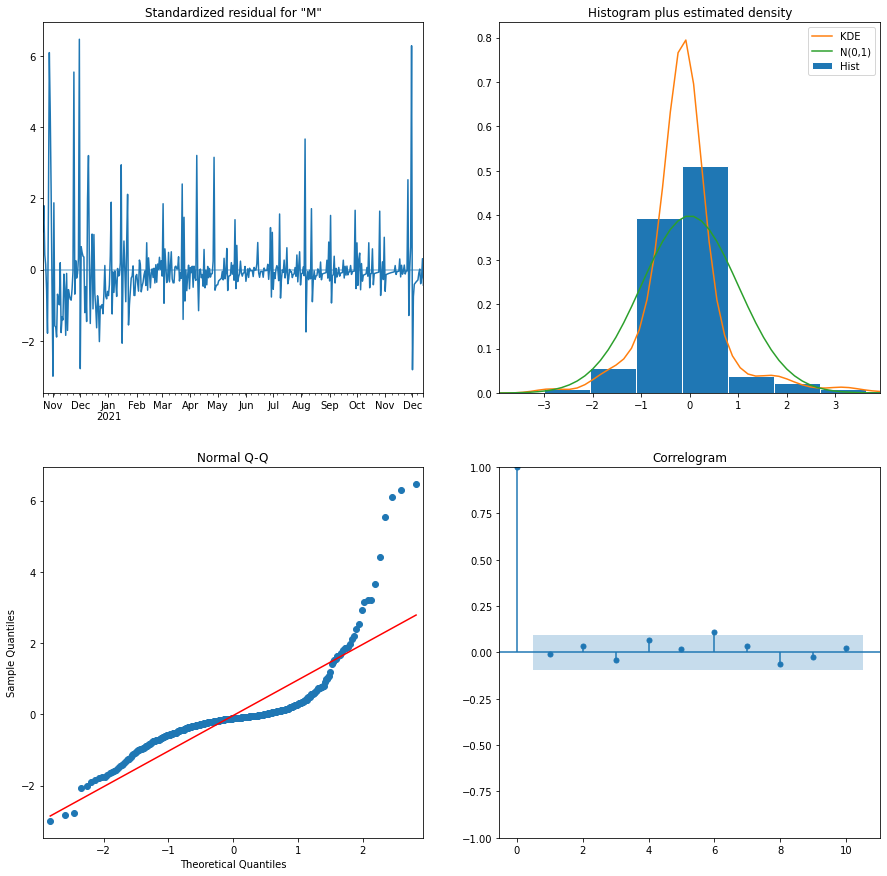

In [101]:
fig=plt.figure(figsize=(15,15))
results.plot_diagnostics(fig=fig)
plt.show()

### 5.4. Prognoza

In [102]:
all_books_forecast = pd.DataFrame({"Książka": ["Między wielkością a zanikiem"], "Pesymistyczny": [confidence["lower"].sum()], "Umiarkowany": [forecast.sum()], "Optymistyczny": [confidence["upper"].sum()]})
all_books_forecast

,Książka,Pesymistyczny,Umiarkowany,Optymistyczny
0,Między wielkością a zanikiem,0,500.518608,8751.793857


## 6. "Mała degeneracja" - prognozy

### 6.1. Eksploracyjna analiza danych

#### Stworzenie serii czasowej dot. książki


In [103]:
df = sale_total["Mała degeneracja"]

#### Wykres liniowy sprzedaży książki

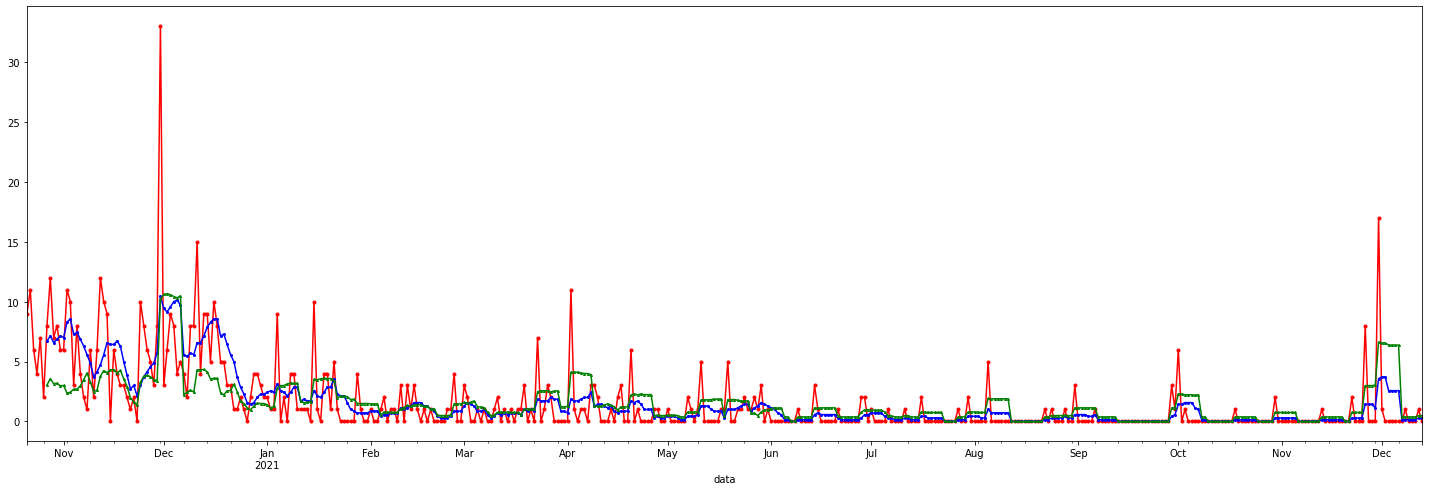

In [104]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(25,8))

# Plot the daily sales
_ = df.plot(ax=ax, marker=".", linestyle="-", color="red", label = "Daily")

# Plot the rolling mean and standard deviation
df_rolling_mean = pd.Series(df).rolling(window=7).mean()
df_rolling_std = pd.Series(df).rolling(window=7).std()

# Plot the rolling mean and standard deviation
_ =  ax.plot(df_rolling_mean, marker="o", markersize=2, linestyle="-", color="blue", label = "Rolling Mean")
_ =  ax.plot(df_rolling_std, marker="^", markersize=2, linestyle="-", color="green", label = "Rolling StDev")
plt.show()

Wykres wskazuje na znaczącą różnicę między danymi do ok. połowy stycznia 2021 i później. <br>
Zmienia się średnia i odchylenie standardowe.<br>
Czy jest sezonowy i stacjonarny? Trudno powiedzieć na podstawie samego wykresu. Zróbmy testy.

##### Test stacjonarności - <i>augmented Dickey-Fuller</i>

In [105]:
# Import test
from statsmodels.tsa.stattools import adfuller

# Get results
adf_results = adfuller(df)

# Print values
print("WYNIKI WZMOCNIONEGO TESTU DICKEYA-FULLERA\n")
print(f"Wartość testu Dickeya-Fullera: {adf_results[0]}.\nIm bardziej ujemna wartość - tym większe prawdopodobieństwo, że szereg czasowy jest stacjonarny.")
print(f"Wartość p: {round(adf_results[1],2)}.")
# Round the critical values
rounded_criticals = {key: round(value, 2) for key, value in adf_results[4].items()} 
print(f"Wartości krytyczne p: {rounded_criticals}.\n")



WYNIKI WZMOCNIONEGO TESTU DICKEYA-FULLERA

Wartość testu Dickeya-Fullera: -2.7809590362721024.
Im bardziej ujemna wartość - tym większe prawdopodobieństwo, że szereg czasowy jest stacjonarny.
Wartość p: 0.06.
Wartości krytyczne p: {'1%': -3.45, '5%': -2.87, '10%': -2.57}.



Wygląda na to, że nasz szereg czasowy jest stacjonarny. Nie chce się w to za bardzo wierzyć :)<br>
Sprawdźmy wszystkie wyniki testu ADF.

In [106]:
adf_results

(-2.7809590362721024,
 0.061045530563344566,
 16,
 402,
 {'1%': -3.446722009322339,
  '5%': -2.868756617175256,
  '10%': -2.570614247667137},
 1851.7430260581336)

OK. Jest stacjonarny. Mniej roboty dla mnie.

#### Sprawdzenie sezonowości

<b>Dekompozycja sezonowa</b>

1) Identyfikacja okresu sezonowego

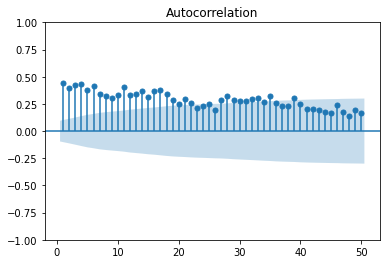

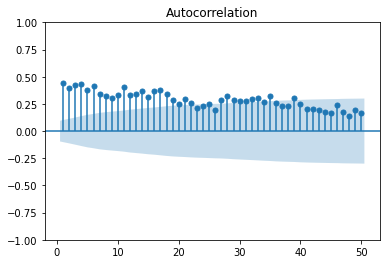

In [107]:
fig, ax = plt.subplots()
plot_acf(df, lags=50, zero=False, ax=ax)

OK, wygląda na to, że nie jest to sezonowy szereg czasowy.

### 6.2. Tworzenie modelu

#### Znajdowanie odpowiedniego rzędu dla modelu

In [108]:
# Ignore warnings
warnings.filterwarnings("ignore")
# Create an empty list
order_aic_bic = []
# Loop over AR and MA order
for p in range(3):
    for q in range(3):
        # Make model and fit it, and append order and scores to the list
        try:
            model = SARIMAX(df, order=(p,0,q))
            results = model.fit()
        except ValueError:
            print(p, q, None, None)
        order_aic_bic.append((p, q, results.aic, results.bic))
# Convert the list to a DF
order_df = pd.DataFrame(order_aic_bic, columns = ["p", "q", "aic", "bic"])
# Step 5. Sort by AIC and print
print(order_df.sort_values("aic"))



   p  q          aic          bic
4  1  1  1964.525751  1976.639364
5  1  2  1965.739526  1981.891010
7  2  1  1965.776448  1981.927932
8  2  2  1968.525728  1988.715083
6  2  0  2049.294952  2061.408565
3  1  0  2090.135778  2098.211520
2  0  2  2122.220228  2134.333841
1  0  1  2154.193127  2162.268869
0  0  0  2246.259417  2250.297288


#### Tworzenie i dopasowanie modelu

In [109]:
# Instantiate a model
model = SARIMAX(df, order=(1,1,1))

# Fit the model
results=model.fit()

# Forecast for the next 365 days
forecast = results.get_forecast(steps=383).predicted_mean

confidence = results.get_forecast(steps=383).conf_int()
confidence.columns = ["lower", "upper"]
for i in range(len(confidence)):
    if confidence["lower"][i] < 0:
        confidence["lower"] = 0

forecast

2021-12-14    0.746380
2021-12-15    0.783097
2021-12-16    0.784904
2021-12-17    0.784992
2021-12-18    0.784997
                ...   
2022-12-27    0.784997
2022-12-28    0.784997
2022-12-29    0.784997
2022-12-30    0.784997
2022-12-31    0.784997
Freq: D, Name: predicted_mean, Length: 383, dtype: float64

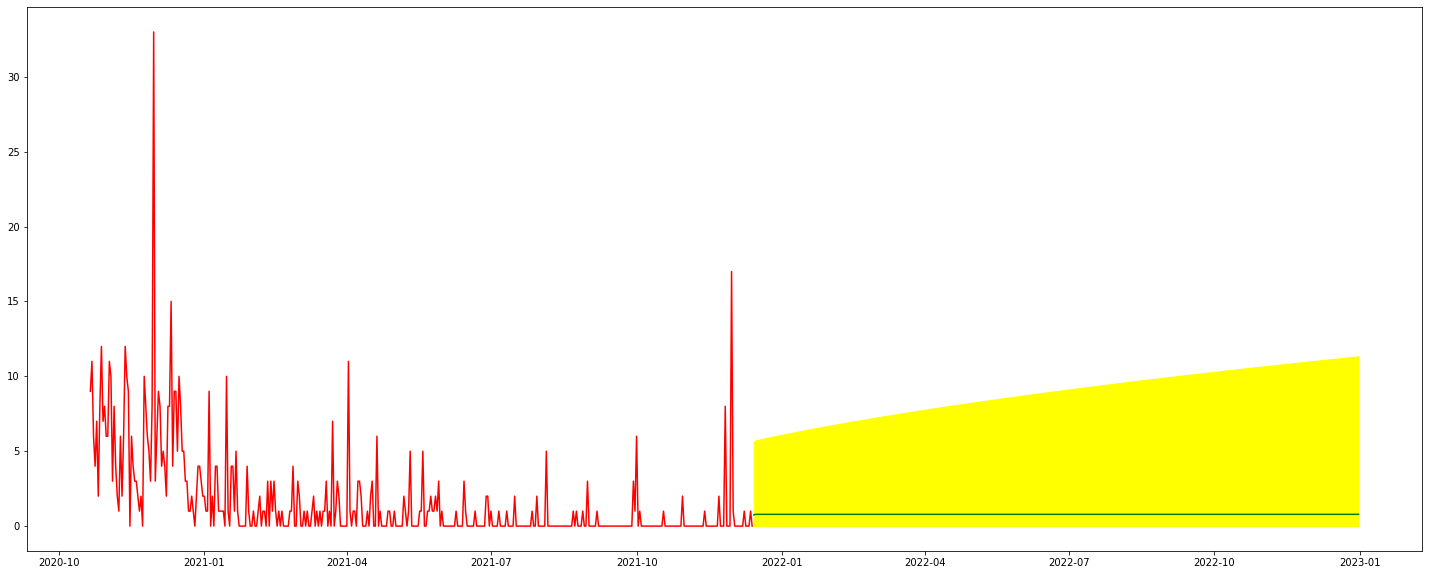

In [110]:
plt.figure(figsize=(25,10))
_ = plt.plot(df, color="red", label="up-to-now")
_ = plt.plot(forecast, color="green", label="prediction")
_ = plt.fill_between(forecast.index, confidence["lower"], confidence["upper"], color="yellow")

### 6.3. Diagnostyka

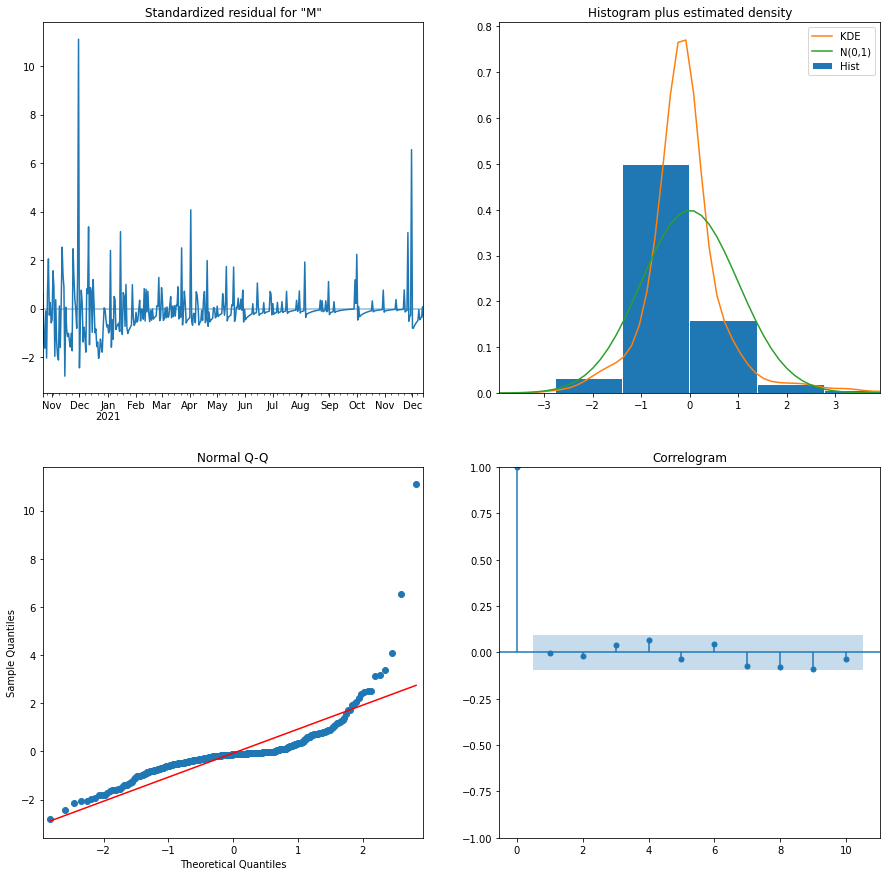

In [111]:
fig=plt.figure(figsize=(15,15))
results.plot_diagnostics(fig=fig)
plt.show()

### 6.4. Prognoza

In [112]:
book_2 = {"Książka": "Mała degeneracja", "Pesymistyczny": confidence["lower"].sum(), "Umiarkowany": forecast.sum(), "Optymistyczny": confidence["upper"].sum()}
all_books_forecast.append(book_2, ignore_index=True)

,Książka,Pesymistyczny,Umiarkowany,Optymistyczny
0,Między wielkością a zanikiem,0,500.518608,8751.793857
1,Mała degeneracja,0,300.613268,3394.053675


## 7. "Od foliowych czapeczek" - prognozy

### 7.1. Eksploracyjna analiza danych

#### Stworzenie serii czasowej dot. książki


In [113]:
df = sale_total["Od foliowych czapeczek..."]

#### Wykres liniowy sprzedaży książki

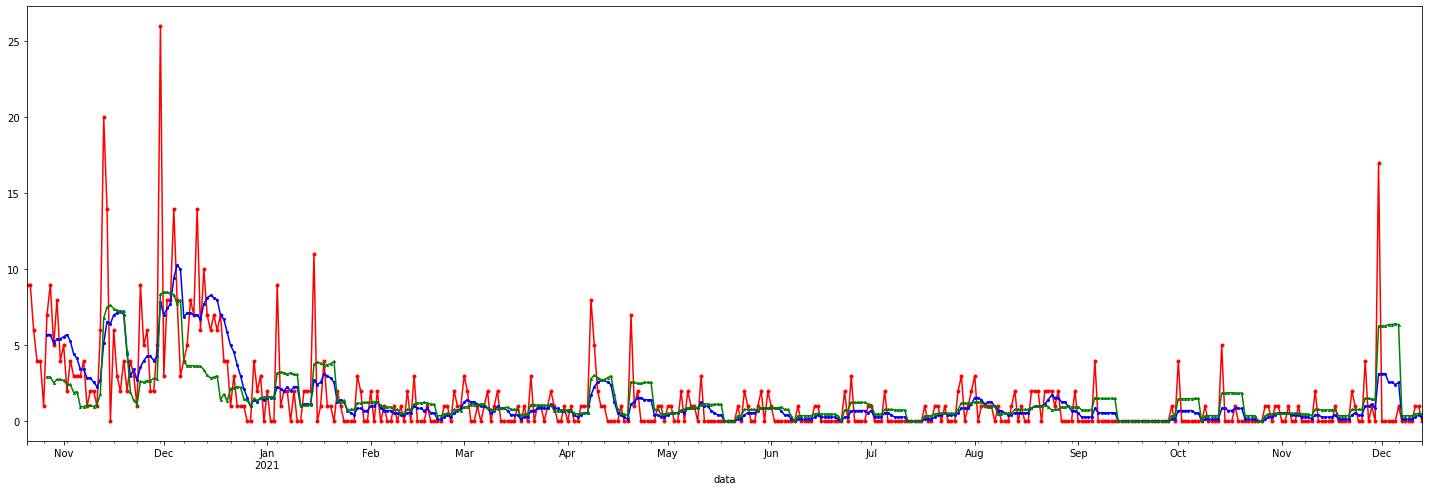

In [114]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(25,8))

# Plot the daily sales
_ = df.plot(ax=ax, marker=".", linestyle="-", color="red", label = "Daily")

# Plot the rolling mean and standard deviation
df_rolling_mean = pd.Series(df).rolling(window=7).mean()
df_rolling_std = pd.Series(df).rolling(window=7).std()

# Plot the rolling mean and standard deviation
_ =  ax.plot(df_rolling_mean, marker="o", markersize=2, linestyle="-", color="blue", label = "Rolling Mean")
_ =  ax.plot(df_rolling_std, marker="^", markersize=2, linestyle="-", color="green", label = "Rolling StDev")
plt.show()

Wykres wskazuje na znaczącą różnicę między danymi do ok. połowy stycznia 2021 i później. <br>
Zmienia się średnia i odchylenie standardowe.<br>
Czy jest sezonowy i stacjonarny? Trudno powiedzieć na podstawie samego wykresu. Zróbmy testy.

##### Test stacjonarności - <i>augmented Dickey-Fuller</i>

In [115]:
# Import test
from statsmodels.tsa.stattools import adfuller

# Get results
adf_results = adfuller(df)

# Print values
print("WYNIKI WZMOCNIONEGO TESTU DICKEYA-FULLERA\n")
print(f"Wartość testu Dickeya-Fullera: {adf_results[0]}.\nIm bardziej ujemna wartość - tym większe prawdopodobieństwo, że szereg czasowy jest stacjonarny.")
print(f"Wartość p: {round(adf_results[1],2)}.")
# Round the critical values
rounded_criticals = {key: round(value, 2) for key, value in adf_results[4].items()} 
print(f"Wartości krytyczne p: {rounded_criticals}.\n")



WYNIKI WZMOCNIONEGO TESTU DICKEYA-FULLERA

Wartość testu Dickeya-Fullera: -2.024919890023624.
Im bardziej ujemna wartość - tym większe prawdopodobieństwo, że szereg czasowy jest stacjonarny.
Wartość p: 0.28.
Wartości krytyczne p: {'1%': -3.45, '5%': -2.87, '10%': -2.57}.



Wygląda na to, że nasz szereg czasowy nie jest stacjonarny. Trzeba będzie dodać jedną diff. <br>
Sprawdźmy wszystkie wyniki testu ADF.

In [116]:
adf_results

(-2.024919890023624,
 0.2757546016639896,
 17,
 401,
 {'1%': -3.4467631030732506,
  '5%': -2.868774682311516,
  '10%': -2.570623877774392},
 1790.871146347616)

#### Sprawdzenie sezonowości

<b>Dekompozycja sezonowa</b>

1) Identyfikacja okresu sezonowego

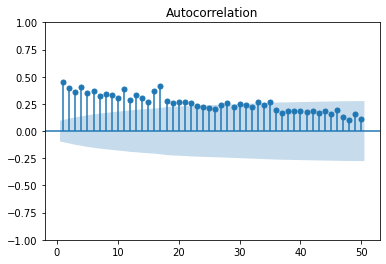

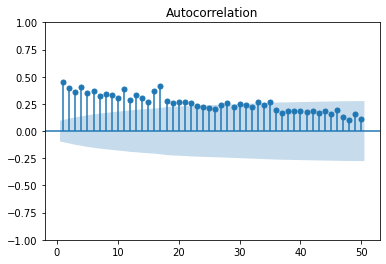

In [117]:
fig, ax = plt.subplots()
plot_acf(df, lags=50, zero=False, ax=ax)

OK, wygląda na to, że nie jest to sezonowy szereg czasowy.

### 7.2. Tworzenie modelu

#### Znajdowanie odpowiedniego rzędu dla modelu

In [118]:
# Ignore warnings
warnings.filterwarnings("ignore")
# Create an empty list
order_aic_bic = []
# Loop over AR and MA order
for p in range(3):
    for q in range(3):
        # Make model and fit it, and append order and scores to the list
        try:
            model = SARIMAX(df, order=(p,0,q))
            results = model.fit()
        except ValueError:
            print(p, q, None, None)
        order_aic_bic.append((p, q, results.aic, results.bic))
# Convert the list to a DF
order_df = pd.DataFrame(order_aic_bic, columns = ["p", "q", "aic", "bic"])
# Step 5. Sort by AIC and print
print(order_df.sort_values("aic"))



   p  q          aic          bic
7  2  1  1902.405432  1918.556916
5  1  2  1902.588722  1918.740206
4  1  1  1903.662785  1915.776398
8  2  2  1906.564991  1926.754345
6  2  0  1967.248641  1979.362254
3  1  0  2006.006051  2014.081793
2  0  2  2033.098694  2045.212307
1  0  1  2076.595390  2084.671132
0  0  0  2171.266651  2175.304522


#### Tworzenie i dopasowanie modelu

In [119]:
# Instantiate a model
model = SARIMAX(df, order=(2,1,1))

# Fit the model
results=model.fit()

# Forecast for the next 365 days
forecast = results.get_forecast(steps=383).predicted_mean

confidence = results.get_forecast(steps=383).conf_int()
confidence.columns = ["lower", "upper"]
for i in range(len(confidence)):
    if confidence["lower"][i] < 0:
        confidence["lower"] = 0

forecast

2021-12-14    0.712334
2021-12-15    0.768097
2021-12-16    0.791287
2021-12-17    0.795206
2021-12-18    0.796196
                ...   
2022-12-27    0.796459
2022-12-28    0.796459
2022-12-29    0.796459
2022-12-30    0.796459
2022-12-31    0.796459
Freq: D, Name: predicted_mean, Length: 383, dtype: float64

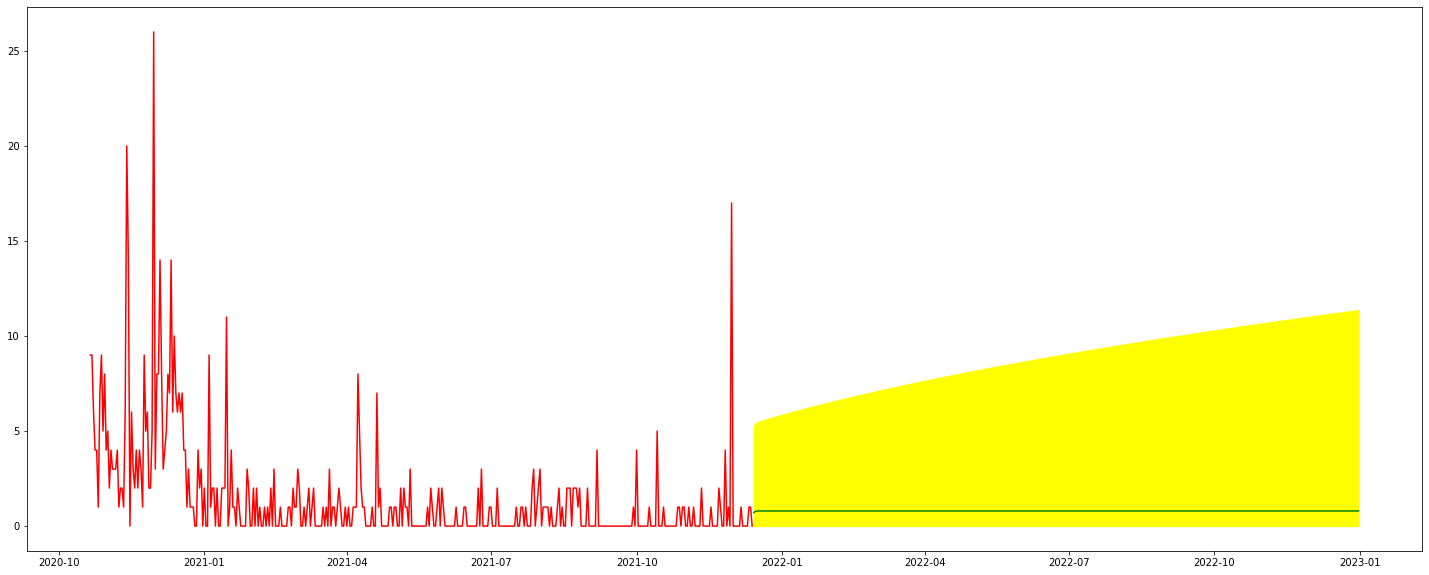

In [120]:
plt.figure(figsize=(25,10))
_ = plt.plot(df, color="red", label="up-to-now")
_ = plt.plot(forecast, color="green", label="prediction")
_ = plt.fill_between(forecast.index, confidence["lower"], confidence["upper"], color="yellow")

### 7.3. Diagnostyka

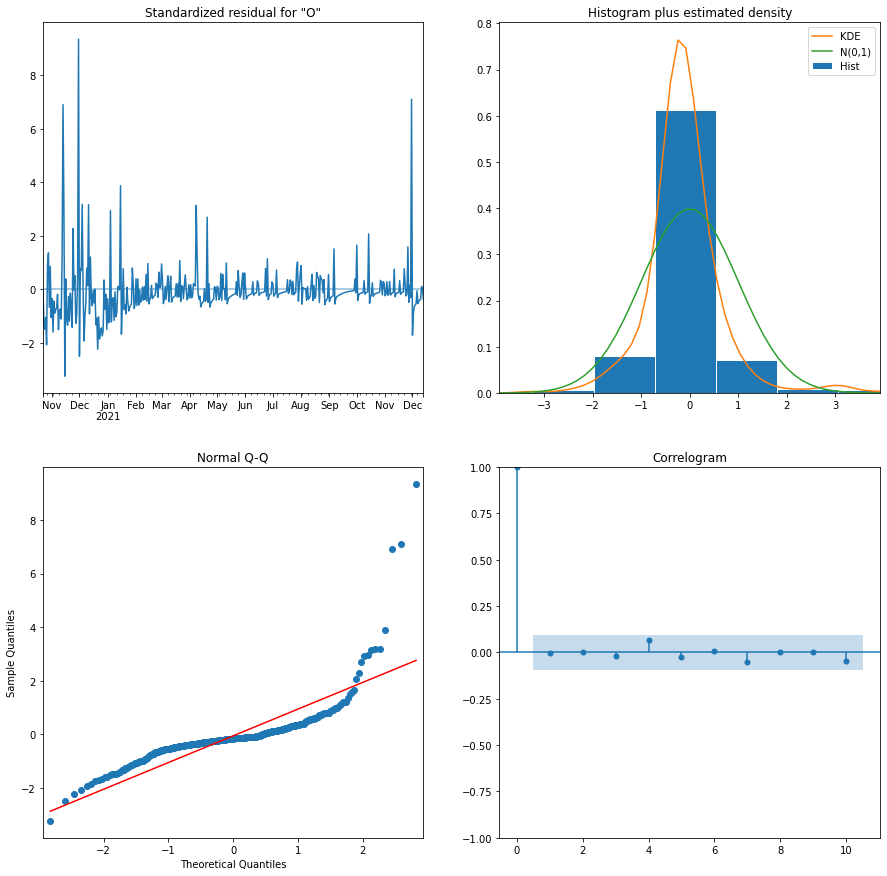

In [121]:
fig=plt.figure(figsize=(15,15))
results.plot_diagnostics(fig=fig)
plt.show()

### 7.4. Prognoza

In [122]:
book_3 = {"Książka": "Od foliowych czapeczek", "Pesymistyczny": confidence["lower"].sum(), "Umiarkowany": forecast.sum(), "Optymistyczny": confidence["upper"].sum()}
all_booall_books_forecast.append(book_3, ignore_index=True)

NameError: name 'all_boall_books_forecast' is not defined